In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import Algorithmia
import numpy as np
import ConfigParser

In [13]:
propertiesFile = "my.properties"
cp = ConfigParser.ConfigParser()
cp.readfp(open(propertiesFile))

client_key = cp.get('algorithmia', 'client')

client = Algorithmia.client(client_key)
algo = client.algo('mtman/SentimentAnalysis/0.1.1')

In [14]:
inputs = ['I absolutely love the Hope Conference.  It is the most fun I have had in months!'
          , 'Radio Statler broadcasts from the Hotel Pennsylvania during Hope xi'
          , 'I hate the government because they spy on my email!!! Its the worst!']

results = []
for input in inputs:
    results.append(algo.pipe(input))

In [15]:
scores = []
for result in results:
    scores.append(result.result)

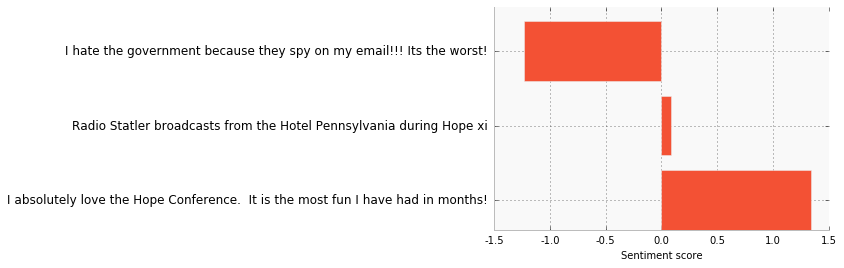

In [16]:
x = np.arange(len(scores))
plt.barh(x, scores)
plt.xlabel('Sentiment score')
plt.yticks(x + 0.4, inputs, fontsize=12)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()

Now, let's see how a series of small test cases get scored.

In [17]:
print(algo.pipe('i hate this').result)

-0.75


In [18]:
print(algo.pipe('i like you').result)

0


In [19]:
rFU = algo.pipe('fuck you')
print(rFU.result)

0.25


The last one is obviously surprising.  One would expect that to be negative sentiment.  The middle is also strange.  Let's now see what happens on a more real world example, in an email I drafted to a company.

In [20]:
email = 'Hi credit card provider.  In my most recent statement, a finance charge of 14.90 is applied.  However, since the last statement, I paid the full previous balance, in fact, I paid several hundred over it.  What is the justification for this charge?'
print(email)

Hi credit card provider.  In my most recent statement, a finance charge of 14.90 is applied.  However, since the last statement, I paid the full previous balance, in fact, I paid several hundred over it.  What is the justification for this charge?


In [21]:
rEmail = algo.pipe(email)
print(rEmail)

AlgoResponse(result=-0.23197091273,metadata=Metadata(content_type='json',duration=0.00975929,stdout=None))


Ok, the score is pretty close to neutral (0.0) which makes sense given that I was trying to be pretty cordial.  How does it change if I tack on "I hate this".

In [22]:
rHate = algo.pipe(email + ' I hate this')
print(rHate)

AlgoResponse(result=-0.98197091273,metadata=Metadata(content_type='json',duration=0.010220991,stdout=None))


As one would expect, sentiment goes negative.  Now let's consider the result when we add in a different explative.

In [23]:
rEmailFu = algo.pipe(email + ' fuck you')
print(rEmailFu)

AlgoResponse(result=0.0180290872705,metadata=Metadata(content_type='json',duration=0.006732819,stdout=None))


Hmmm.  I notice something suspicious.  Adding this explative increases the sentiment, which is consistent with the earlier discovery that the wrong sentiment is applied to this addendum.  Can we reverse engineer what's going on here?

In [25]:
print(rEmailFu.result - rEmail.result)
print(rFU.result)

0.25
0.25


Indeed, the different between the score of the email with and with out this addendum is exactly the score of that result alone.  Clearly, this is a somewhat naive model that doesn't take content into consideration well.  It seems to have some weights for individual words, regardless of their use.  Not bad for a first try though!  Kudos to the author for providing this basic service.  There's room for improvement here.  We could regard this as a "hack" because now that I understand how this model works, I can exploit it.  If I knew of a system that was scoring sentiment based on this, I could bias that system.